In [1]:
# from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
import IPython.core.display as di
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code on/off</button>''', raw=True)

Toggle code on/off

# Testing Evaluation / Mock Classification

This notebook:
- loads in `params` and `clf` obtained from `train_random_forest.ipynb`
- loads in an experiment file ('04-21...' which was NOT used to train `clf`)
- at some sampling frequency, makes data vectors of all 128 ROIs and uses `clf` to classify the state
- compares different "decision rules" one can use to call a fly as during-summiting

Things one can tweak to affect model performance:
- the forms of decision rules (P(dur) > P(alive) for x frames, ...)
- the frequency of classification

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import sys; sys.path.append('..')
from utils.time_utils import frame_from_local_time, local_time_from_frame
from utils.load_data_utils import get_data_from_exp_dir
from utils.prediction_utils import longest_1_stretch_end
from utils.classifier_plot_utils import pred_legend,  plot_traj, plot_feature_vec, \
    add_hr_x_axis, state_colors, plot_confusion
from utils.process_data_utils import get_frames, roi_first_app_of_condition,\
    make_X_y_from_expmt, make_X_from_frames_roi,    \
    make_y_from_frames_roi, count_pred_true_matrix, get_fprs_tprs_aucs
from scipy.stats import rankdata
import bottleneck as bn
import pickle 
import os
import time

C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def set_font_sizes(SMALL_SIZE=14, MEDIUM_SIZE=16, LARGE_SIZE=20):
    '''
    Sets font size for matplotlib
    From: https://stackoverflow.com/a/39566040
    '''
    font = {'family':'sans-serif',
            'sans-serif':['Arial'],
            'size': SMALL_SIZE}
    plt.rc('font', **font)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title
    
set_font_sizes()

In [4]:
save_figs = True
figure_plot_dir = 'test_classification_figures'

if save_figs:
    if not os.path.isdir(figure_plot_dir):
        os.makedirs(figure_plot_dir)

### Load in data

Make sure this data wasn't used to train the classifier!

In [5]:
behavior_data_dir = '../../Data/Data by figure/Fig 4 + Supp/'
test_dir = os.path.join(behavior_data_dir, '04-21-2019-20-51-44__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/')
# fix long filenames issue
test_dir = '\\\\?\\'+os.path.abspath(test_dir)

### Load in trained classifier

The following cell has two options: 
- the `params_` and `clf_` files with suffix `used_in_experiments.p` are the model files used in all classifier experiments, which were used to generate Figs 4E-G, 4-S1B
- the `params_` and `clf_` files with suffix `example_classifier_model.p` are the model files generated by running `training/train_random_forest.ipynb` with `save_model=True`

In [6]:
model_dir = '../models/'

#params = pickle.load(open(os.path.join(model_dir, "params_example_classifier_model.p"), "rb" ))
#clf = pickle.load(open(os.path.join(model_dir, "clf_example_classifier_model.p"), "rb" ))

params = pickle.load(open(os.path.join(model_dir, "params_used_in_experiments.p"), "rb" ))
clf = pickle.load(open(os.path.join(model_dir, "clf_used_in_experiments.p"), "rb" ))

In [7]:
dic_class_to_i = dict((y,x) for (x,y) in enumerate(clf.classes_))
dic_i_to_class = dict((x,y) for (x,y) in enumerate(clf.classes_))
params['do_continuous'] = 0

In [8]:
# initialize training, validation data
test_X = np.zeros((0, params['num_features']))
test_y = np.zeros((0,))

# load in data into necessary form
log_cols = ['expmt', 'ROI', 'frame', 'y', 'type']
roi_log_df = pd.DataFrame(columns=log_cols)

np.random.seed(1234)

print('Reading in {}'.format(test_dir))
test_ed, test_df = get_data_from_exp_dir(test_dir)
t_x, t_y, t_log = make_X_y_from_expmt(test_ed, test_df, params)
mask = np.all(np.isnan(t_x), axis=1)
t_x = t_x[~mask]; t_y = t_y[~mask]; t_log = t_log[~mask]
expmt_log_df = pd.DataFrame(np.column_stack((
     [test_dir]*len(t_y), np.array(t_log), t_y, ['test']*len(t_y))), 
     columns=log_cols)
test_X = np.concatenate((test_X, t_x))
test_y = np.concatenate((test_y, t_y))
roi_log_df = pd.concat((roi_log_df, expmt_log_df))

Reading in \\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-21-2019-20-51-44__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3


In [9]:
test_log = roi_log_df[roi_log_df.type == 'test']
test_log.loc[:, 'ROI'] = pd.to_numeric(test_log.ROI)
test_log.loc[:, 'frame'] = pd.to_numeric(test_log.frame)
test_rois = test_log.ROI.unique()

### Testing error

(Figure 4E)

In [10]:
test_y_pred = clf.predict(test_X)
test_log['y_pred'] = test_y_pred

In [11]:
# compute errors
test_err = sum(test_y_pred != test_y) / len(test_y)
print('test err: {:.5f}'.format(test_err))

test err: 0.20857


In [12]:
def replace_class_labels(x):
    rx = np.char.replace(x, 'Alive', 'non-')
    rx = np.char.replace(rx, 'dur', 'during')
    rx = np.char.replace(rx, 'pre', 'pre-')
    rx = np.char.replace(rx, 'post', 'post-')
    return rx

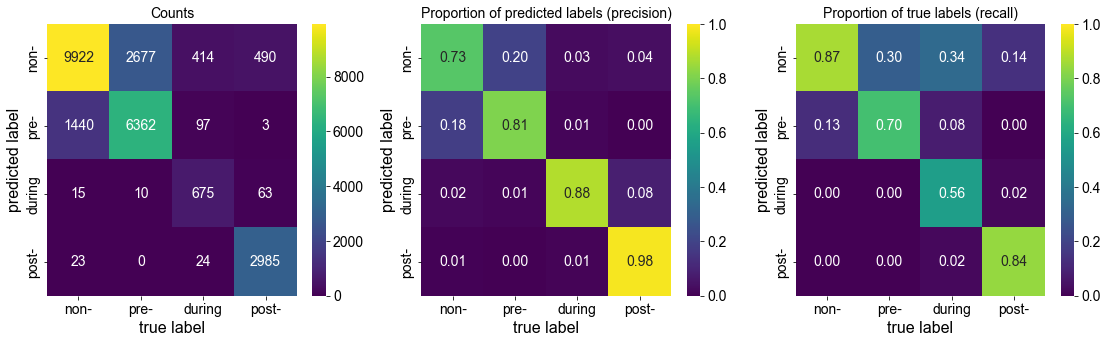

In [13]:
set_font_sizes()

# compute precision, recall
y_pred = clf.predict(test_X)
y_true = test_y

plt.figure(figsize=(19,5))

cm_df = plot_confusion(replace_class_labels(y_pred), 
                       replace_class_labels(y_true), 
                       ['non-', 'pre-', 'during', 'post-'])

plt.subplots_adjust(wspace=0.2)

if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_test_frames_confusion_matrix.png'), bbox_inches='tight',dpi=300)
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_test_frames_confusion_matrix.pdf'), bbox_inches='tight')

plt.show()

Weaker, but similar performance as seen on the validation data.

## Classify data

We'll start classifying starting at hour 24 (recall the earliest tau is around 33 hours) ((and I don't think this was stated earlier -- the start time of an experiment, say 5 pm, is logged in the filename and then all future timepoints are labeled in local time, without modding by 24, so midnight is t = 24, 9 AM is t = 33, etc.))

We also must set a sampling frequency. Need a better number here, but from actually running the classifier in the last week of the rotation, it would take roughly a minute in total to load in the data, classify, and email updates. This notebook sets a conservative frequency of classification every 4 minutes.

The RandomForestClassifier outputs class probabilities, so we now go through the data and store classification probabilities for each ROI:

In [14]:
#frame_start_classification = np.where(test_ed['ts'] > 24)[0][0]
frame_start_classification = np.where(test_ed['ts'] > 21)[0][0]
classification_frequency = int(4 *60*3) # in frames
classification_frames = np.arange(frame_start_classification, len(test_ed['ts']), classification_frequency)

In [15]:
ROIs = 1+np.arange(128)
## shape: classification_frames  * nROIs * numFeatures
allXes = np.zeros((len(classification_frames ), len(ROIs), params['num_features']))
trueYs = np.array([['nannannannan']*len(ROIs) for x in range(len(classification_frames))])
predYprobs = np.zeros((len(classification_frames ), len(ROIs), 4))

In [16]:
# go through frames and store data vectors (allXes)

nanROIs = np.zeros(len(ROIs))
frame_times = []
for i in range(len(classification_frames)):
    t0 = time.time()
    # we're looking at just one frame
    fr = classification_frames[i]
    
    # now just go through each ROI
    for ir in range(len(ROIs)):   
        
        roi = ROIs[ir]
        
        trueYs[i, ir] = make_y_from_frames_roi([fr], roi, test_ed, test_df, params)
            
        # only process relevant trajectories 
        # that aren't all NaN values 
        if not nanROIs[ir]:

            # get relevant frames
            prev_frames, curr_frames = get_frames(fr, params)
            grab_frames = np.concatenate((prev_frames, curr_frames))

            # get data
            ypos = test_ed['ypos'][:, roi-1] 

            # mark if ROI is all NaN's
            if np.all(np.isnan(ypos)):
                nanROIs[ir] = 1 
                # don't bother extracting ypos, speed 
                # (taking the moving average takes time)
                allXes[i, ir, :] = np.zeros(params['num_features'])          
            
            else:
                # otherwise, continue processing and add to X matrix
                spd = test_ed['speed'][:, roi-1]
                if params['do_mov_avg']:
                    ypos = bn.move_mean(ypos, window=params['wl'], min_count=1)
                    spd = bn.move_mean(spd, window=params['wl'], min_count=1)

                # make X data, store it in allXes
                X_ex = make_X_from_frames_roi(fr, grab_frames, ypos, spd, test_ed)  
                allXes[i, ir, :] = X_ex  
    end_time = time.time()
    frame_times.append(end_time-t0)
nanROIs = nanROIs.astype(bool)

..\utils\process_data_utils.py:67: RuntimeWarning: invalid value encountered in log
  max(np.log(params['PREV_LB']), np.log(base_frame-params['CURR_WINDOW_WIDTH'])),


How long it takes to classify all ROIs at a time:

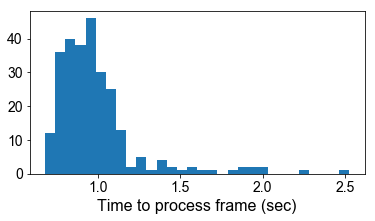

In [17]:
plt.figure(figsize=(6,3))
plt.hist(frame_times, bins=30)
plt.xlabel('Time to process frame (sec)')
plt.show()

In [18]:
# now go through allXes and use clf to classify, store in predYprobs
goodROIpos = np.arange(128)[~nanROIs]
for i in range(len(classification_frames)):
    pred_set = clf.predict_proba(allXes[i, goodROIpos, :])
    predYprobs[i, goodROIpos] = pred_set

### Compare decision rules

Now we'll compare different decision rules (P(dur) > a threshold, P(dur) > P(alive), etc.) and see how many summiting flies  were truly predicted to be summiting:

In [19]:
# compute frames predicting summiting under certain conditions:
# e.g. the first frame in which
#      class probability(during) > 0.7, or > 0.5, or where 
#      it exceeds the other class probabilities (argmax)
# if there's a lot of false positives, consider making decisions 
# on more than just the first frame where condition true

dic_class_to_i = dict((y,x) for (x,y) in enumerate(clf.classes_))
dic_i_to_class = dict((x,y) for (x,y) in enumerate(clf.classes_))

dur_over_alive_prob = predYprobs[:, :, dic_class_to_i['dur']] - predYprobs[:, :, dic_class_to_i['Alive']] > 0
consec_5_dur_over_alive = np.apply_along_axis(longest_1_stretch_end, 0, dur_over_alive_prob, 5)
consec_3_dur_over_alive = np.apply_along_axis(longest_1_stretch_end, 0, dur_over_alive_prob, 3)
consec_2_dur_over_alive = np.apply_along_axis(longest_1_stretch_end, 0, dur_over_alive_prob, 2)
consec_5_alive_03 = np.apply_along_axis(longest_1_stretch_end, 0, predYprobs[:, :, dic_class_to_i['dur']] > 0.3, 5)
consec_5_alive_05 = np.apply_along_axis(longest_1_stretch_end, 0, predYprobs[:, :, dic_class_to_i['dur']] > 0.5, 5)
consec_2_alive_03 = np.apply_along_axis(longest_1_stretch_end, 0, predYprobs[:, :, dic_class_to_i['dur']] > 0.3, 2)
consec_2_alive_05 = np.apply_along_axis(longest_1_stretch_end, 0, predYprobs[:, :, dic_class_to_i['dur']] > 0.5, 2)

calling_methods = [
    roi_first_app_of_condition(classification_frames, predYprobs[:, :, dic_class_to_i['dur']] >= 0.7),
    roi_first_app_of_condition(classification_frames, predYprobs[:, :, dic_class_to_i['dur']] >= 0.5),
    roi_first_app_of_condition(classification_frames, np.argmax(predYprobs, axis=2) == dic_class_to_i['dur']),
    roi_first_app_of_condition(classification_frames, consec_5_dur_over_alive),
    roi_first_app_of_condition(classification_frames, consec_3_dur_over_alive),
    roi_first_app_of_condition(classification_frames, consec_2_dur_over_alive),
    roi_first_app_of_condition(classification_frames, consec_5_alive_03),
    roi_first_app_of_condition(classification_frames, consec_5_alive_05),
    roi_first_app_of_condition(classification_frames, consec_2_alive_03),
    roi_first_app_of_condition(classification_frames, consec_2_alive_05)
]

calling_methods_labels = [
    'P(dur) > 0.7\nfirst',
    'P(dur) > 0.5\nfirst',
    'P(dur) > P(else)\nfirst',
    'P(dur) > P(alive)\n5 straight',
    'P(dur) > P(alive)\n3 straight',
    'P(dur) > P(alive)\n2 straight',
    'P(dur) > 0.3\n5 straight',
    'P(dur) > 0.5\n5 straight',
    'P(dur) > 0.3\n2 straight',
    'P(dur) > 0.5\n2 straight'
]

nmeth = len(calling_methods_labels)

# fill in frames, local time of predicted summiting in dataframe
test_df_local = test_df.copy()

time_diffs = []
count_matrices = []
for i in range(len(calling_methods)):
    meth_frames = calling_methods[i]
    meth_times = local_time_from_frame(calling_methods[i], test_df.start_time[0])
    test_df_local['meth{}_frame'.format(i)] = meth_frames
    test_df_local['meth{}_time'.format(i)] = meth_times
    time_diff = test_df_local['meth{}_time'.format(i)] - test_df_local.tau_hr
    time_diffs.append(time_diff[~np.isnan(time_diff)])
    count_matrices.append(
        count_pred_true_matrix(test_df_local, 'meth{}_time'.format(i)))

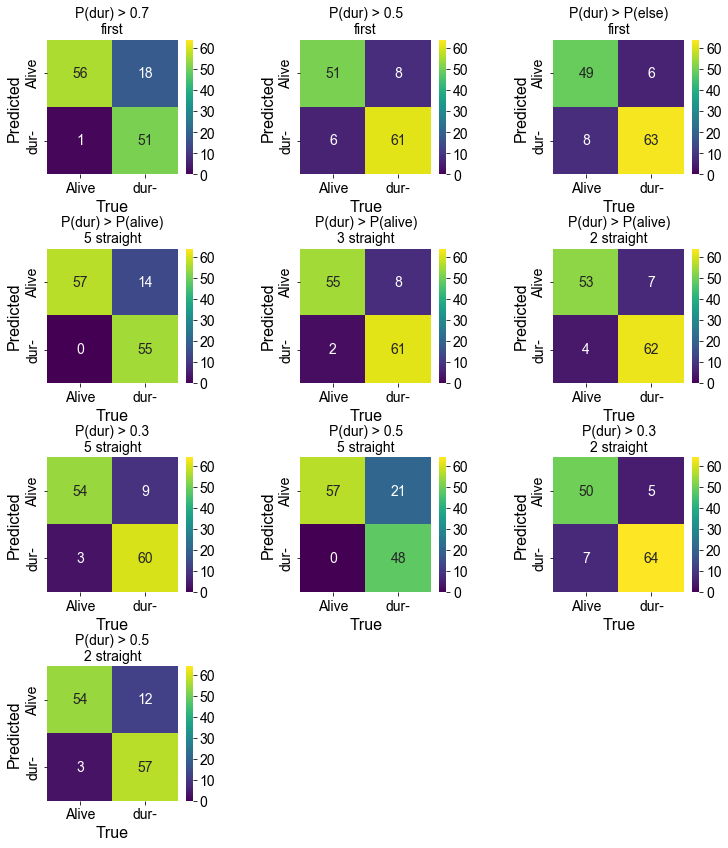

In [20]:
max_cnt = np.max([np.max(c) for c in count_matrices])
nplots = 3*(nmeth // 3 + (nmeth % 3 != 0))


plt.figure(figsize=(12,3.5*(nplots/3)))

for i in range(nmeth):
    plt.subplot(nplots/3, 3, i+1)
    plt.title(calling_methods_labels[i])
    sns.heatmap(pd.DataFrame(count_matrices[i],
                             columns=['Alive', 'dur-'], 
                             index=['Alive', 'dur-']),
                annot=True, cmap='viridis', vmin=0, vmax=max_cnt)
    plt.ylabel('Predicted'); plt.xlabel('True')
plt.subplots_adjust(hspace=0.55, wspace=0.55)
plt.show()

## confusion matrix post-cutoffs
(Figure 4F)

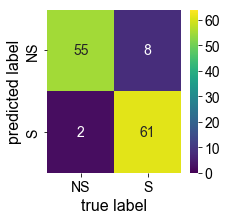

In [21]:
max_cnt = np.max([np.max(c) for c in count_matrices])
nplots = 3*(nmeth // 3 + (nmeth % 3 != 0))


plt.figure(figsize=(3,3))

i = 4
#plt.title(calling_methods_labels[i])
sns.heatmap(pd.DataFrame(count_matrices[i],
                         columns=['NS', 'S'], 
                         index=['NS', 'S']),
            annot=True, cmap='viridis', vmin=0, vmax=max_cnt)
plt.ylabel('predicted label'); plt.xlabel('true label')
#plt.title('classifier test performance')

if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_test_performance.png'), bbox_inches='tight',dpi=300)
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_test_performance.pdf'), bbox_inches='tight')
plt.show()

All the different methods have different recalls/precisions. It looks like a good one based on this testing data is P(dur) > P(alive) for 3 straight classification frames, since it has a rather pure set of true during-summiting flies.

We can also visualize the time it took each decision rule to call summiters relative to the manually-called tau time:

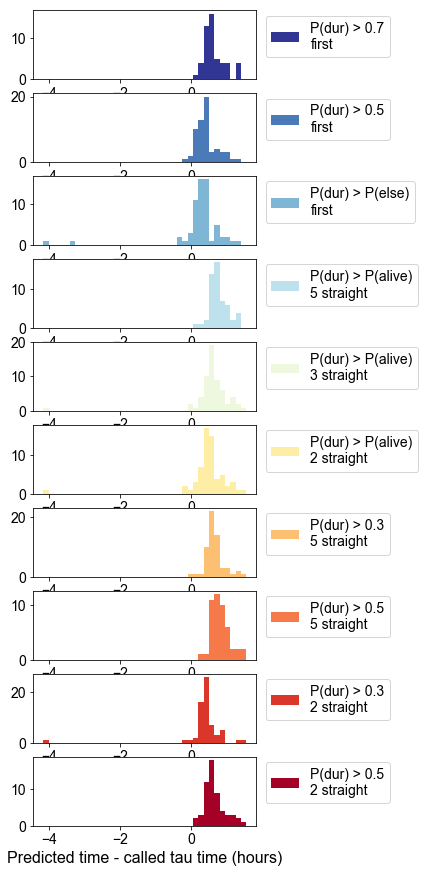

In [22]:
# plot difference between 
xlb = np.min([np.min(d) for d in time_diffs])
xub = np.max([np.max(d) for d in time_diffs])
nmeth = len(calling_methods)
bins = np.arange(xlb, xub, 0.15)
plt.figure(figsize=(4,1.5*nmeth))


cm_meth = plt.cm.get_cmap('RdYlBu_r')
meth_colors = [cm_meth(x) for x in np.linspace(0, 1, nmeth)]


for i in range(nmeth):
    plt.subplot(nmeth, 1, i+1)
    plt.hist(time_diffs[i], bins=bins, color=meth_colors[i], # density=True,
         label=calling_methods_labels[i])
    plt.legend(loc='upper left', bbox_to_anchor=(1.01,1.025))

plt.xlabel('Predicted time - called tau time (hours)')
plt.show()

### Compute non-summiting score

In [23]:
# go through frames and store data vectors (allXes)
all_non_summiter_scores = []
nanROIs = np.zeros(len(ROIs))
frame_times = []
for i in range(1,len(classification_frames)):
    t0 = time.time()
    # we're looking at just one frame
    fr = classification_frames[i]
    
    ypos = test_ed['ypos'][:fr, :]
    spd = test_ed['speed'][:fr, :]
    
    # compute non-summiting score
    # then, extract the class probabilities over that time 
    posYprobs = predYprobs[:i, :, :]
    # next, for each ROI, identify fraction of time that P(alive) > all others
    frac_alive_argmax = (np.argmax(posYprobs, axis=2) == dic_class_to_i['Alive']).sum(0) / posYprobs.shape[0]
    ### average P(alive):
    average_p_alive = np.mean(posYprobs[:, :, dic_class_to_i['Alive']], axis=0)
    # then, for each ROI, find the max value of P(dur)
    max_dur_prob = np.max(posYprobs[:, :, dic_class_to_i['dur']], axis=0)
    # then, for each ROI, find fraction of time indices in which speed = 0
    frac_speeds_0 = np.sum(pd == 0, axis=0) / spd.shape[0]
    # then, for each ROI, find its current speed (over past 'wl' time window)
    cur_speeds = np.mean(spd[-params['wl']:,:], 0)
    # finally, compute its percentile rank (0: speed=0, 1: fastest speed)
    cur_speed_pctiles = (rankdata(cur_speeds, 'min') -1)/127
    
    # putting it all together, this non-summiter score is
    # (fraction of time P(alive) > P(else)) * 
    # (1 - max[P(dur)]) * 
    # (fraction of speeds 0 < 0.9) *
    # (1 - cur_speed_percentile)
    non_summiter_scores = average_p_alive*(1-max_dur_prob)*(frac_speeds_0 < 0.9)*(cur_speed_pctiles)
    all_non_summiter_scores.append(non_summiter_scores)
all_non_summiter_scores = np.array(all_non_summiter_scores)

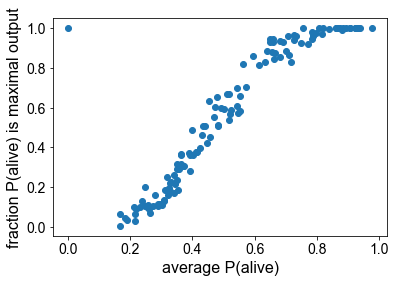

In [24]:
plt.figure()
plt.plot(average_p_alive, frac_alive_argmax, 'o')
plt.xlabel('average P(alive)')
plt.ylabel('fraction P(alive) is maximal output')
plt.show()

### Plot classification probabilities

Now we'll plot the entire motion data and trajectory of class probabilities for each ROI, along with if/when each decision rule calls an ROI summiting (bars in the speed panel).

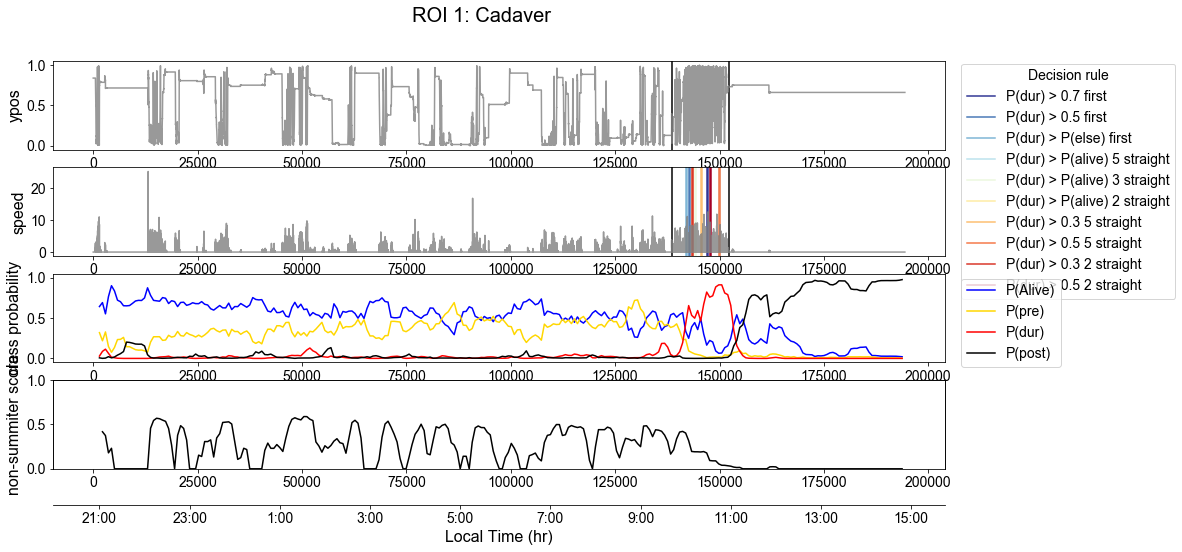

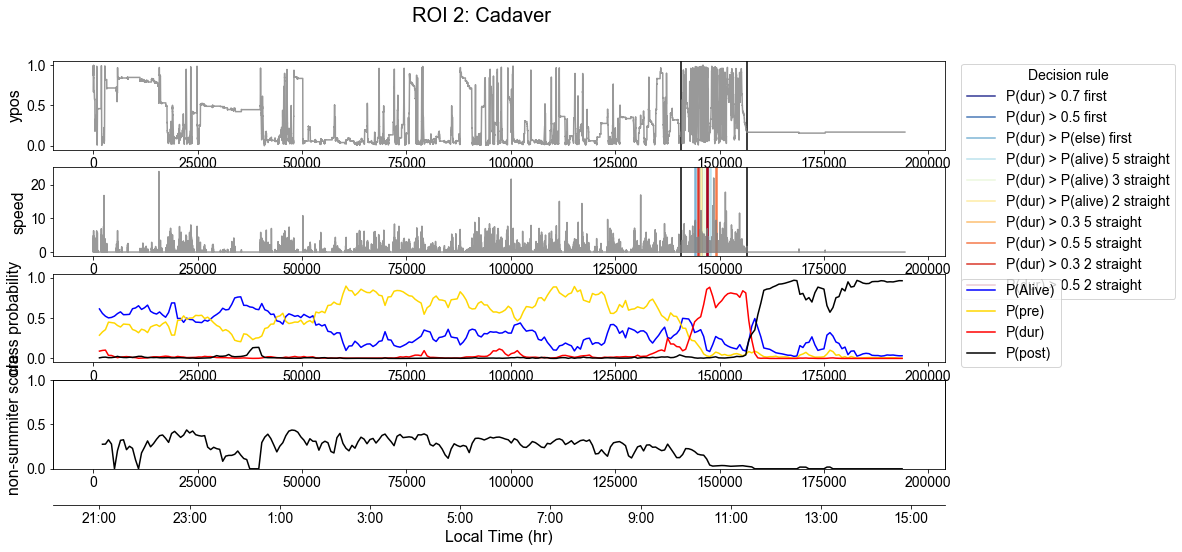

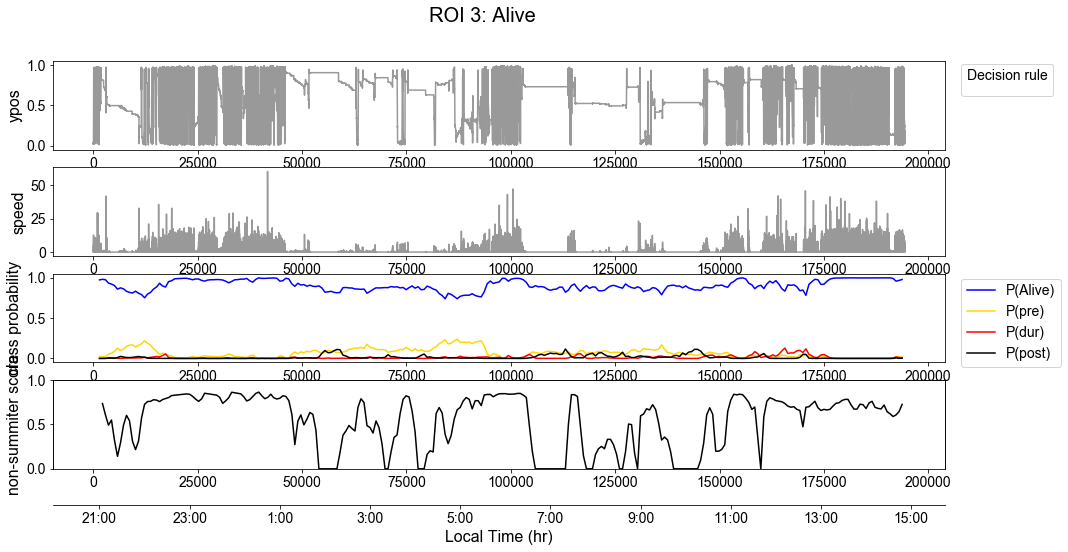

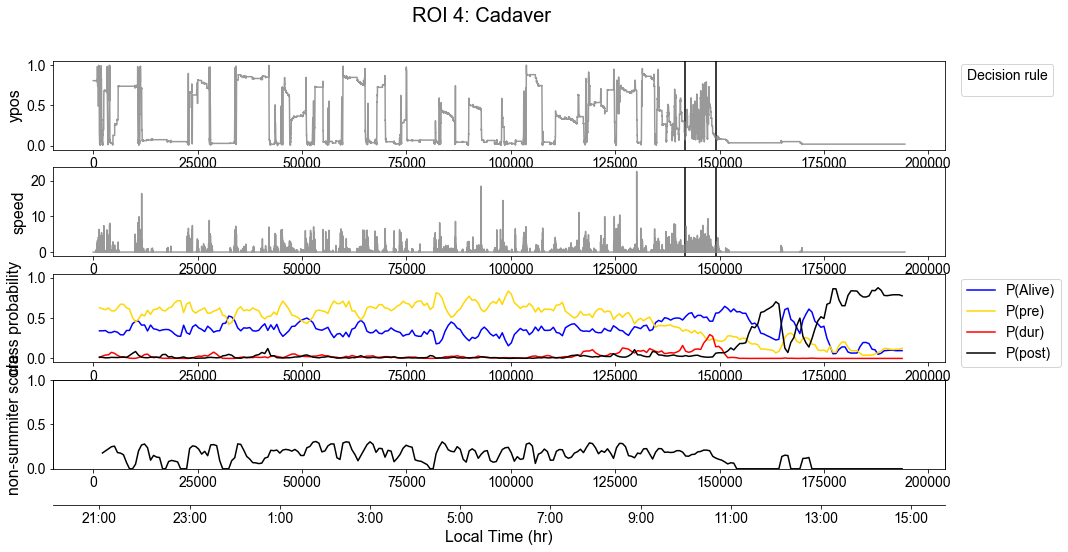

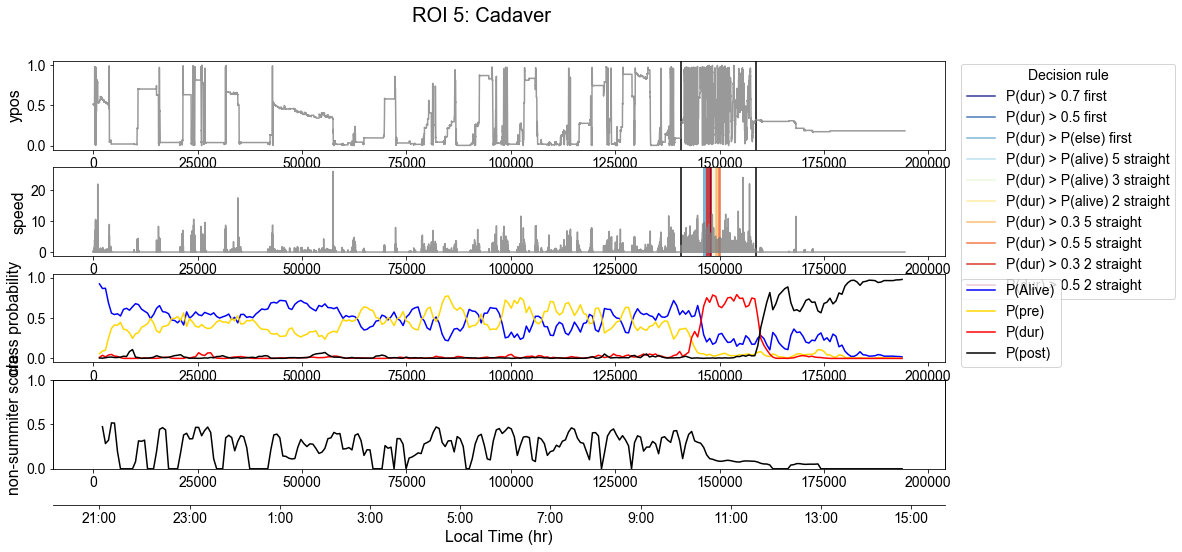

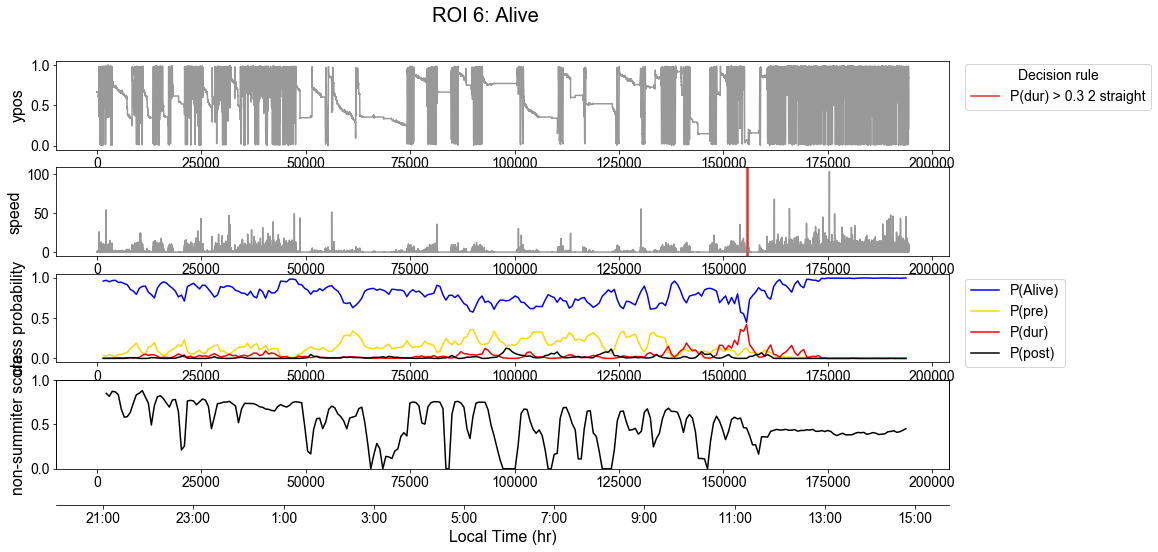

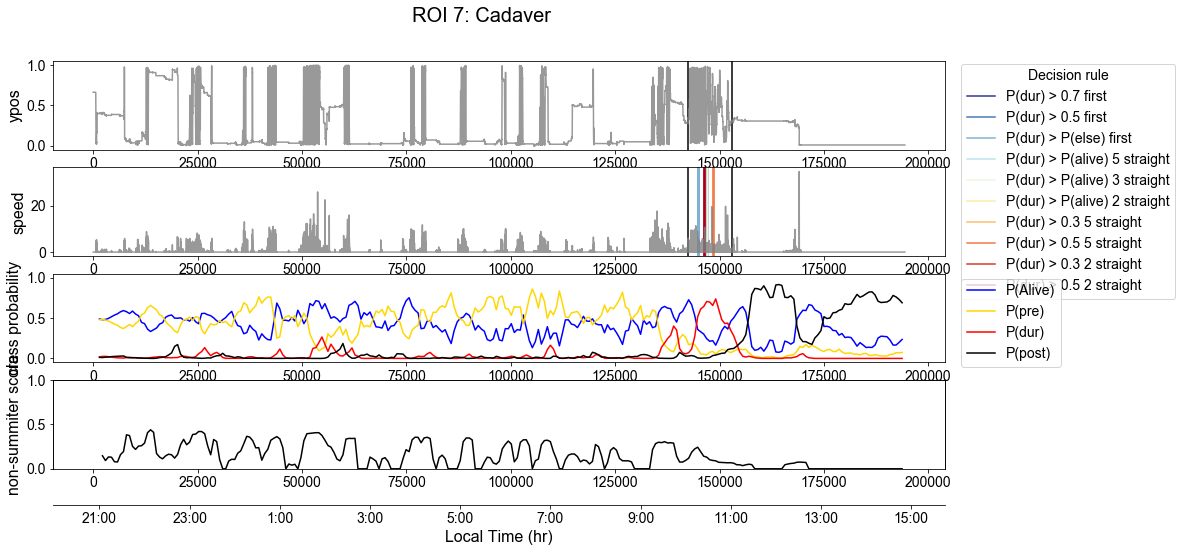

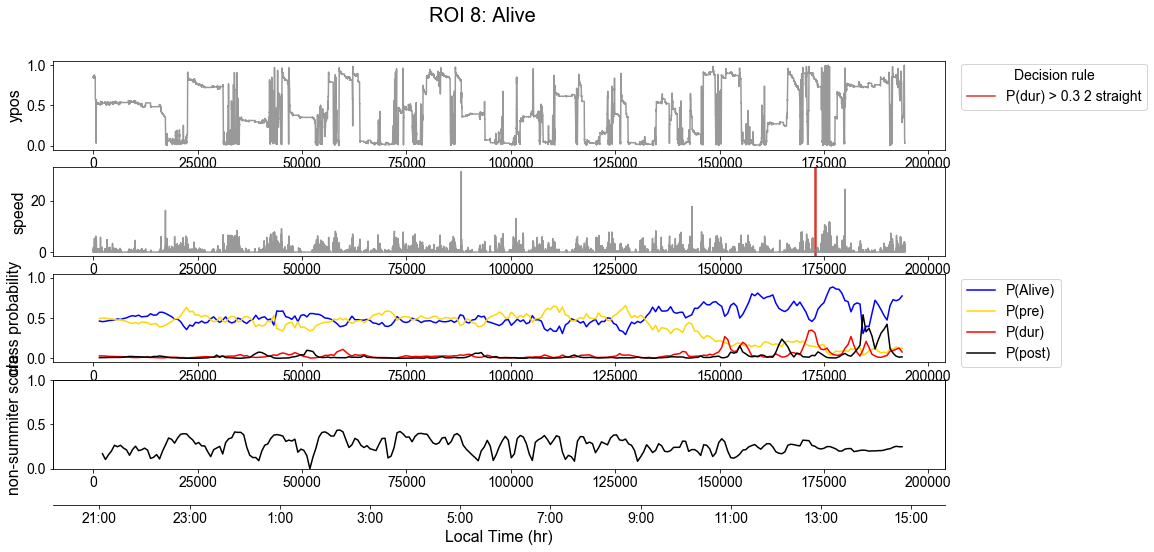

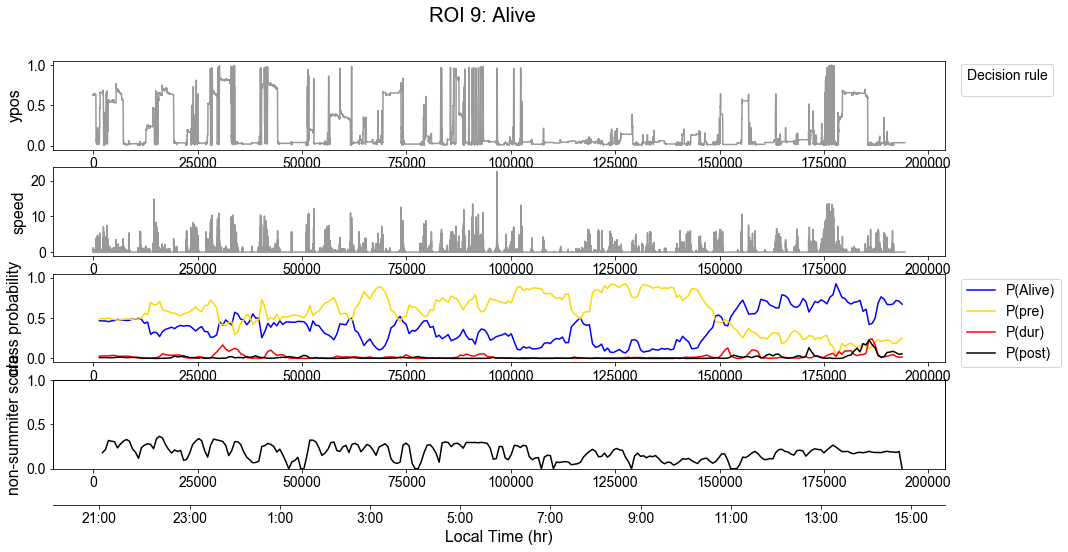

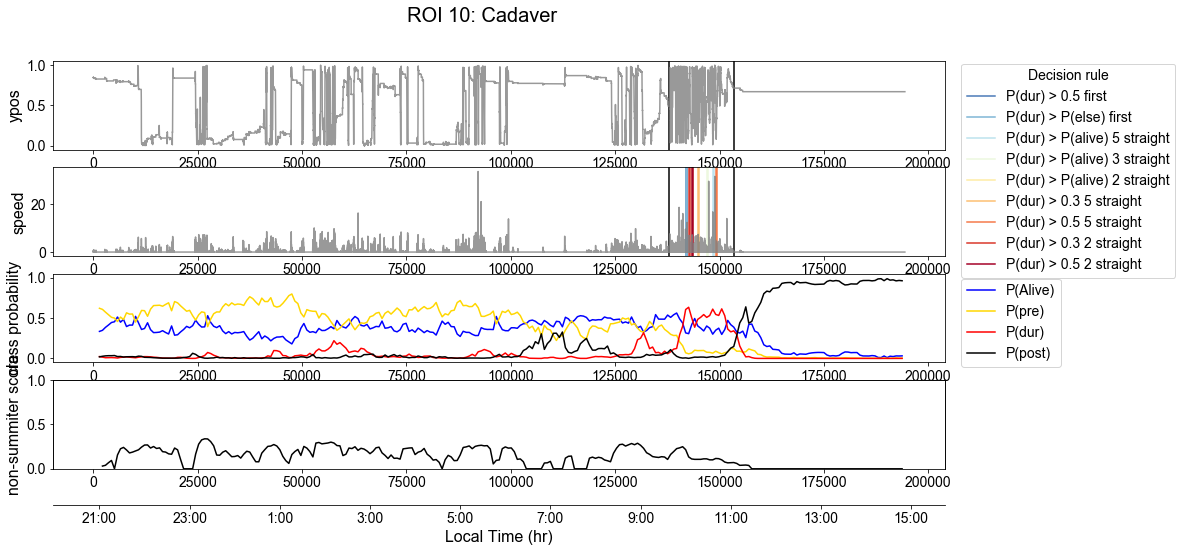

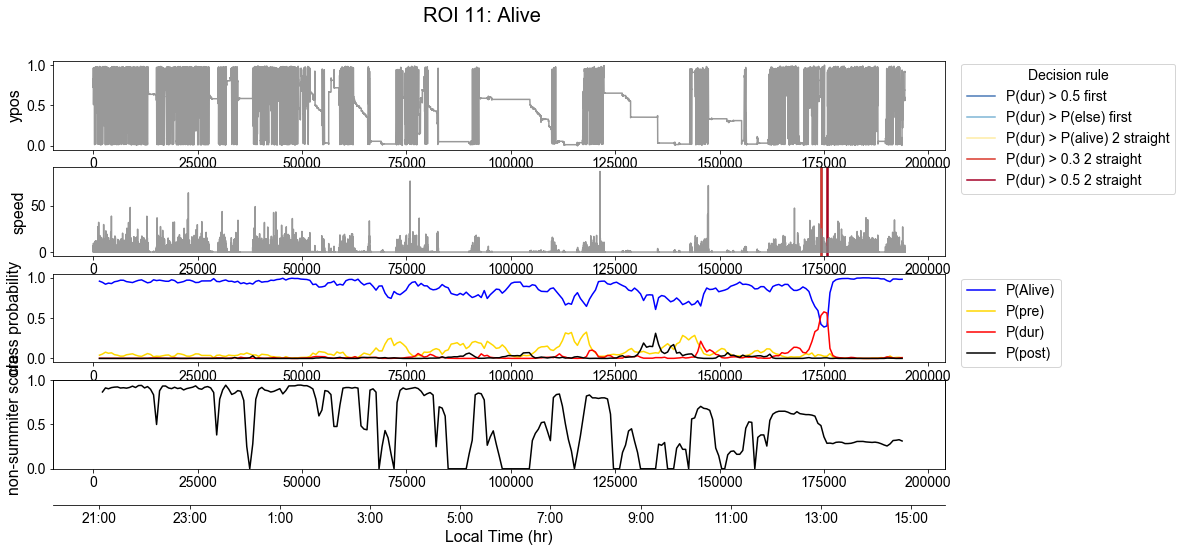

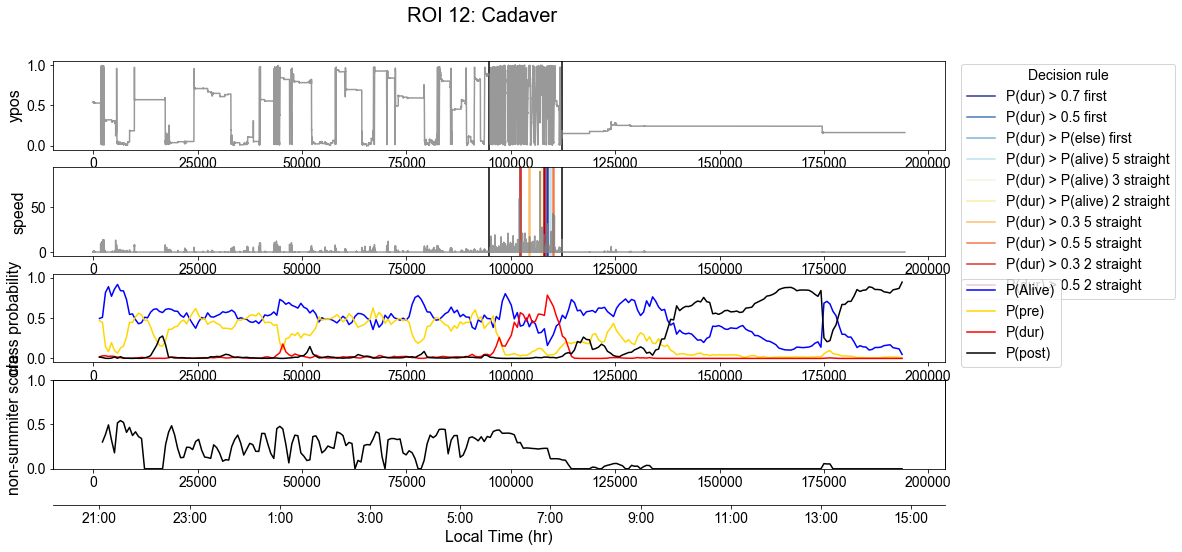

In [25]:
alph = 1
for i in np.arange(12):#range(len(test_rois)):
    roi = i+1#test_rois[i]    
    
    subdf = test_log[(test_log.expmt == test_dir) & (test_log.ROI == roi)]
    pred_alive = subdf.y_pred == 'Alive'; true_alive = subdf.y == 'Alive'
    pred_pre = subdf.y_pred == 'pre'; true_pre = subdf.y == 'pre'
    pred_dur = subdf.y_pred == 'dur'; true_dur = subdf.y == 'dur'
    pred_post = subdf.y_pred == 'post'; true_post = subdf.y == 'post'
    
    state = 'alive' if test_log.y.iloc[0] == 'Alive' else 'cad'
    
    if nanROIs[i]:
        print('NAN!')
        
    called_frames = np.array([test_df_local.iloc[i]['meth{}_frame'.format(j)] for j in range(nmeth)]).reshape((nmeth, 1))
    
    frames_pred_alive = subdf[pred_alive].frame
    frames_pred_pre = subdf[pred_pre].frame
    frames_pred_dur = subdf[pred_dur].frame
    frames_pred_post = subdf[pred_post].frame
    frames_pred_alive_wrong = subdf[pred_alive & ~true_alive].frame
    frames_pred_pre_wrong = subdf[pred_pre & ~true_pre].frame
    frames_pred_dur_wrong = subdf[pred_dur & ~true_dur].frame
    frames_pred_post_wrong = subdf[pred_post & ~true_post].frame
    frames_true_alive = subdf[true_alive].frame
    frames_true_pre = subdf[true_pre].frame
    frames_true_dur = subdf[true_dur].frame
    frames_true_post = subdf[true_post].frame
    num_wrong = len(np.concatenate((frames_pred_alive_wrong, 
                                    frames_pred_pre_wrong, 
                                    frames_pred_dur_wrong, 
                                    frames_pred_post_wrong)))
    num_total = len(frames_true_alive) + len(frames_true_pre) + \
                len(frames_true_dur) + len(frames_true_post)
    
    num_pred_dur_wrong = len(frames_pred_dur_wrong)
    tot_pred_dur = np.sum(pred_dur)
    
    if True:#num_wrong > 0:
        
        plt.figure(figsize=(16,7.5))
        ax0, ax1 = plot_traj(roi, test_df, test_ed, npl=4,
                          frame_sets=[], 
                          frame_cols=[],
                          frame_sets_bottom=called_frames,
                          frame_cols_bottom=meth_colors,
                          title='', frame_alph=1, frame_lw=2.5,
                          ypos_color='gray', spd_color='gray',
                          speed_mult=0.31*3)
        
        
        which_notnan = np.where(~np.isnan(called_frames))[0]
        class_legend = [Line2D([0], [0], color=meth_colors[j]) for j in which_notnan]
        labs = [calling_methods_labels[j].replace('\n', ' ') for j in which_notnan]
        ax0.legend(class_legend, labs,
                   loc='upper left', bbox_to_anchor=(1.01, 1.05), 
                   title='Decision rule')       
        ax3 = plt.subplot(413, sharex=ax1)
        for ic in [dic_class_to_i[x] for x in ['Alive', 'pre', 'dur', 'post']]:
            ax3.plot(classification_frames, predYprobs[:, roi-1, ic], color=state_colors[dic_i_to_class[ic]], 
                 alpha=alph, label='P({})'.format(clf.classes_[ic]))
        ax3.set_xlim(ax1.get_xlim())
        ax3.legend(bbox_to_anchor=(1.01, 1.025), loc='upper left')
        ax3.set_ylim(-0.05, 1.05)
        ax3.set_ylabel('class probability')
        ax4 = plt.subplot(414, sharex=ax3)
        ax4.plot(classification_frames[1:], all_non_summiter_scores[:, i], color='black')
        ax4.set_ylim(0, 1)
        ax4.set_ylabel('non-summiter score')
        ax5 = add_hr_x_axis(ax4, test_df)
        plt.show()

In [26]:
dic_class_label = {'Alive': 'non-summiting', 
                   'dur': 'during summiting',
                   'pre': 'pre-summiting' ,
                   'post': 'post-summiting' }

### example summiting/non-summiting classifier probabilities

(Figure 4-S1B)

In [27]:
PLOTTING_ROIS = [17, 89, 103, 116, # summiting
                 33, 108, 120      # non
                ]

# distilled summiting/non-summiting example for Fig 4-S1A
PLOTTING_ROIS = [89,
                108]

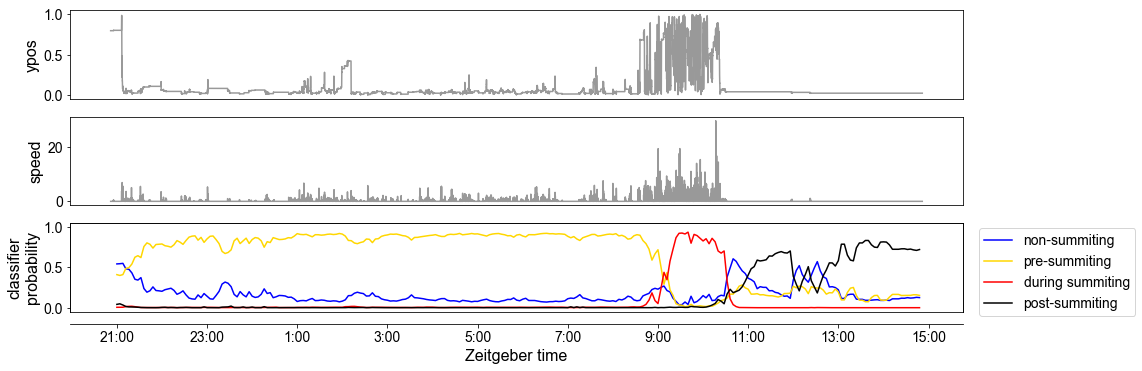

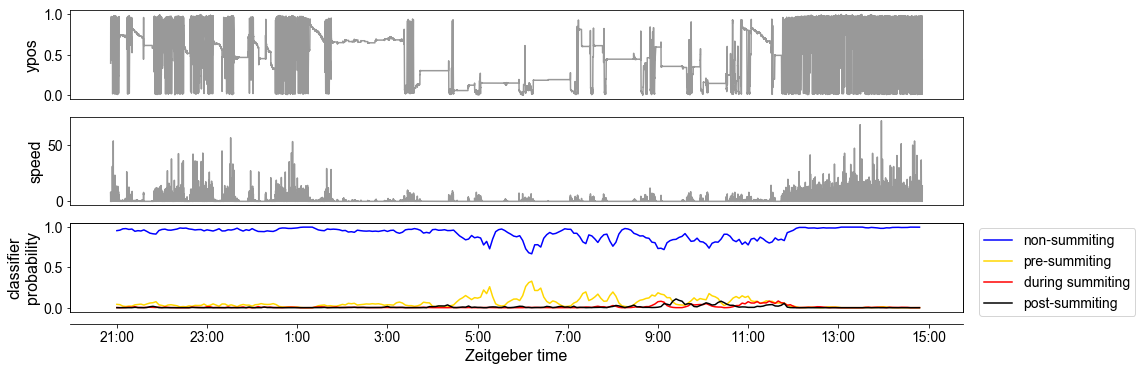

In [28]:
test_rois = np.arange(1,129)#[120, 108, 98]#, 108]

alph = 1
which_meths_to_include = [4]#, 5]

nmeth_include = len(which_meths_to_include)

for i in range(len(test_rois)):
    roi = test_rois[i]    
    
    subdf = test_log[(test_log.expmt == test_dir) & (test_log.ROI == roi)]
    pred_alive = subdf.y_pred == 'Alive'; true_alive = subdf.y == 'Alive'
    pred_pre = subdf.y_pred == 'pre'; true_pre = subdf.y == 'pre'
    pred_dur = subdf.y_pred == 'dur'; true_dur = subdf.y == 'dur'
    pred_post = subdf.y_pred == 'post'; true_post = subdf.y == 'post'
    
    state = 'alive' if test_log.y.iloc[0] == 'Alive' else 'cad'
        
    if nanROIs[i]:
        print('NAN!')
        
    called_frames = np.array([test_df_local.iloc[roi-1]['meth{}_frame'.format(j)] for j in which_meths_to_include]).reshape((nmeth_include, 1))
    
    frames_pred_alive = subdf[pred_alive].frame
    frames_pred_pre = subdf[pred_pre].frame
    frames_pred_dur = subdf[pred_dur].frame
    frames_pred_post = subdf[pred_post].frame
    frames_pred_alive_wrong = subdf[pred_alive & ~true_alive].frame
    frames_pred_pre_wrong = subdf[pred_pre & ~true_pre].frame
    frames_pred_dur_wrong = subdf[pred_dur & ~true_dur].frame
    frames_pred_post_wrong = subdf[pred_post & ~true_post].frame
    frames_true_alive = subdf[true_alive].frame
    frames_true_pre = subdf[true_pre].frame
    frames_true_dur = subdf[true_dur].frame
    frames_true_post = subdf[true_post].frame
    num_wrong = len(np.concatenate((frames_pred_alive_wrong, 
                                    frames_pred_pre_wrong, 
                                    frames_pred_dur_wrong, 
                                    frames_pred_post_wrong)))
    num_total = len(frames_true_alive) + len(frames_true_pre) + \
                len(frames_true_dur) + len(frames_true_post)
    
    num_pred_dur_wrong = len(frames_pred_dur_wrong)
    tot_pred_dur = np.sum(pred_dur)
    
    if True:#num_wrong > 0:
        
        plt.figure(figsize=(16,7.5))
        ax0, ax1 = plot_traj(roi, test_df, test_ed, npl=4,
                          frame_sets=[], 
                          frame_cols=[],
                          frame_sets_bottom=called_frames,
                          frame_cols_bottom=['k', 'k'],
                          show_start_end=False,
                          title='', frame_alph=0,
                          ypos_color='gray', spd_color='gray',
                          speed_mult = 0.31*3)
        
        which_notnan = np.where(~np.isnan(called_frames))[0]
        class_legend = [Line2D([0], [0], color=meth_colors[which_meths_to_include[j]]) for j in which_notnan]
        labs = [calling_methods_labels[which_meths_to_include[j]].replace('\n', ' ') for j in which_notnan]
           
        ax3 = plt.subplot(413, sharex=ax1)
        for ic in [dic_class_to_i[x] for x in ['Alive', 'pre', 'dur', 'post']]:
            ax3.plot(classification_frames, 
                     predYprobs[:, roi-1, ic], 
                     color=state_colors[dic_i_to_class[ic]], 
                 alpha=alph, label=dic_class_label[clf.classes_[ic]])
        ax3.set_xlim(ax1.get_xlim())
        ax3.legend(bbox_to_anchor=(1.01, 1.025), loc='upper left')
        ax3.set_ylim(-0.05, 1.05)
        ax3.set_ylabel('classifier\nprobability')
        #ax4 = plt.subplot(414, sharex=ax3)
        #ax4.plot(classification_frames[1:], all_non_summiter_scores[:, i], color='black')
        #ax4.set_ylim(0, 1)
        #ax4.set_ylabel('non-summiter score')
        
        for ax in [ax0, ax1, ax3]:
            ax.get_xaxis().set_visible(False)
            #ax = add_hr_x_axis(ax, test_df)
        
        mystate = 'non' if np.all(np.isnan(called_frames)) else 'summiting'
        
        ax4 = add_hr_x_axis(ax3, test_df, zpos=12)
        ax4.set_xlabel('Zeitgeber time')
        ax0.set_title('')
        plt.suptitle('')
        if roi in PLOTTING_ROIS:
            if save_figs:
                plt.savefig(os.path.join(figure_plot_dir, 'roi{}_{}.png'.format(roi, mystate)), bbox_inches='tight')#,dpi=300)
                plt.savefig(os.path.join(figure_plot_dir, 'roi{}_{}.pdf'.format(roi, mystate)), bbox_inches='tight')
            plt.show()
        else:
            plt.close()

## Plot historical/recent frames

(Figure 4B)

In [29]:
t_ed, t_df = get_data_from_exp_dir(test_dir)
roi = 128

In [30]:
plot_params = params.copy()
#plot_params['NCURR'] = 3
#plot_params['NPREV'] = 18#14

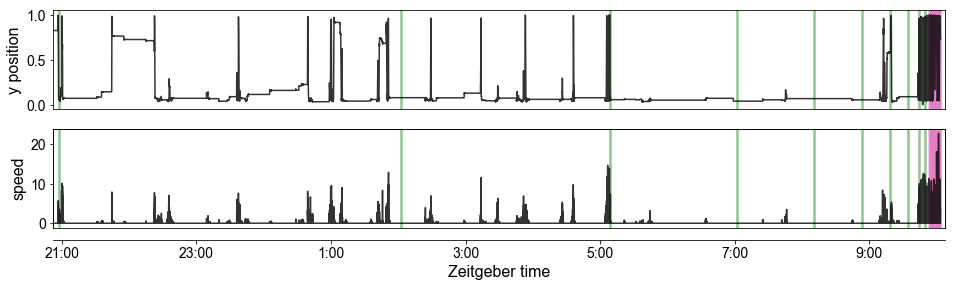

In [31]:
STOP_FRAME = 142500
fs = [STOP_FRAME]

prev_color = 'forestgreen'
curr_color = 'tab:pink'

for fr in fs:

    base_frame = fr

    # get relevant frames
    prev_frames, curr_frames = get_frames(base_frame, plot_params)
    grab_frames = np.concatenate((prev_frames, curr_frames))
    
    # get raw data
    ypos = t_ed['ypos'][:, roi-1] 
    spd = t_ed['speed'][:, roi-1]

    # make X, y
    X_ex = make_X_from_frames_roi(base_frame, grab_frames, ypos, spd, t_ed)
    y_ex = make_y_from_frames_roi(curr_frames, roi, t_ed, t_df, plot_params)
    
    plt.figure(figsize=(16,4))
    ax0, ax1 = plot_traj(roi, t_df, t_ed, 
             frame_sets = [prev_frames, curr_frames],
             frame_cols = [prev_color, curr_color],
             frame_sets_bottom = [prev_frames, curr_frames],
             frame_cols_bottom = [prev_color, curr_color],
             end_frame = STOP_FRAME,
             show_start_end = False,
             frame_alph = 0.5, frame_lw=2.5,
             speed_mult = 0.31 * 3
                        )
    
    for ax in [ax0, ax1]:
        ax.get_xaxis().set_visible(False)
        # 8 to 10 am ax.set_xlim(STOP_FRAME-23000, STOP_FRAME+800)
        # 2 to 10 am ax.set_xlim(54000, STOP_FRAME+800)
        # ax.set_xlim(75000, STOP_FRAME+800) # 4 to 10 am
        ax.set_xlim(0, STOP_FRAME+800)
    ax0.set_ylabel('y position')
    ax2 = add_hr_x_axis(ax1, t_df, zpos=12, hr_delta=2)
    ax2.set_xlabel('Zeitgeber time')
    plt.suptitle('')
    if save_figs:
        plt.savefig(os.path.join(figure_plot_dir, 'feature_trace_roi_{}.png'.format(roi)), bbox_inches='tight',dpi=300)
        plt.savefig(os.path.join(figure_plot_dir, 'feature_trace_roi_{}.pdf'.format(roi)), bbox_inches='tight')
    plt.show()

### Misclassified data

Here's some examples of vectors that are labelled as during summiting but are truly alive, pre-, dur-, or post-summiting. They all seem quite hard to distinguish!

In [32]:
where_pred_dur_true_dur = np.where((test_y_pred == 'dur') & (test_y == 'dur'))[0]
where_pred_dur_true_pre = np.where((test_y_pred == 'dur') & (test_y == 'pre'))[0]
where_pred_dur_true_post = np.where((test_y_pred == 'dur') & (test_y == 'post'))[0]
where_pred_dur_true_alive = np.where((test_y_pred == 'dur') & (test_y == 'Alive'))[0]
sub_dur_dur = test_X[where_pred_dur_true_dur]
sub_dur_pre = test_X[where_pred_dur_true_pre]
sub_dur_post = test_X[where_pred_dur_true_post]
sub_dur_alive = test_X[where_pred_dur_true_alive]

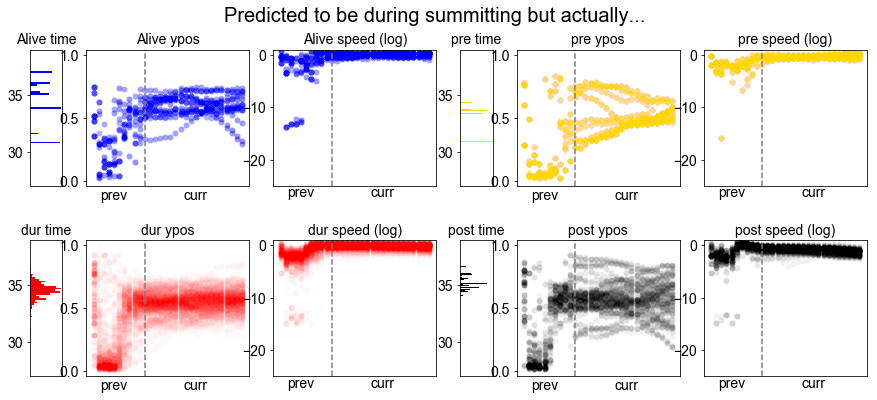

In [33]:
plt.figure(figsize=(15,6))
plt.suptitle('Predicted to be during summitting but actually...')
gs = gridspec.GridSpec(2, 6, width_ratios=[1,5,5,1,5,5])
ax1, ax2, ax3 = plot_feature_vec(sub_dur_alive, 'Alive', gs, 0, params, ntoplot=500, alph=5)
ax4, ax5, ax6 = plot_feature_vec(sub_dur_pre, 'pre', gs, 3, params, ntoplot=500, alph=5)
ax7, ax8, ax9 = plot_feature_vec(sub_dur_dur, 'dur', gs, 6, params, ntoplot=500, alph=5)
ax10, ax11, ax12 = plot_feature_vec(sub_dur_post, 'post', gs, 9, params, ntoplot=500, alph=5)
plt.subplots_adjust(hspace=0.4)
plt.show()

Hopefully this notebook is a useful look into how a real-time classifier can work. 

For the actual real-time classifier code, go to `run_classifier.py`!